### Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

_This notebook is inspired by the awesome_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _by Berkeley_

For starters, let's define a simple MDP from this picture:
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Markov_Decision_Process.svg/800px-Markov_Decision_Process.svg.png' width=300px>
_img by MistWiz (Own work) [Public domain], via Wikimedia Commons_

In [11]:
# If you Colab, uncomment this please
# !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/week02_value_based/mdp.py

transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [12]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [13]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ",
      mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Optional: Visualizing MDPs

You can also visualize any MDP with the drawing fuction donated by [neer201](https://github.com/neer201).

You have to install graphviz for system and for python. For ubuntu just run:

1. `sudo apt-get install graphviz`
2. `pip install graphviz`
3. restart the notebook

__Note:__ Installing graphviz on some OS (esp. Windows) may be tricky. However, you can ignore this part alltogether and use the standart vizualization.

In [14]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


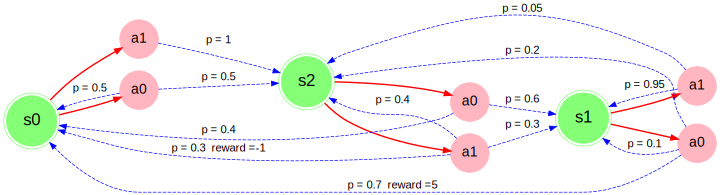

In [15]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, \
        plot_graph_optimal_strategy_and_state_values

    display(plot_graph(mdp))

### Value Iteration

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [16]:
%%writefile mdp_get_action_value.py
#help(mdp.get_transition_prob)
import numpy as np
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """

    # YOUR CODE HERE
    q = 0
    for s1 in mdp.get_next_states(state, action).keys():
        p_value = mdp.get_transition_prob(state, action, s1)
        r = mdp.get_reward(state, action, s1)
        v = state_values[s1]
        q += p_value * (r + gamma * v)
    print(q)
    return q

Overwriting mdp_get_action_value.py


In [19]:
from mdp_get_action_value import get_action_value

In [20]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.allclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.allclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

0.6900000000000002
3.9499999999999997


Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [21]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0

    # <YOUR CODE>
    v_list = []    
    for a in mdp.get_possible_actions(state):
        v_list.append(get_action_value(mdp, state_values, state, a, gamma))
    return max(v_list)

In [22]:
test_Vs_copy = dict(test_Vs)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 0.69)
assert test_Vs == test_Vs_copy, "please do not change state_values in get_new_state_value"

0.9
1.8
0.54
0.6900000000000002


Finally, let's combine everything we wrote into a working value iteration algo.

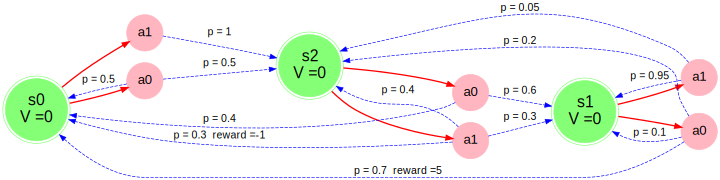

0.0
0.0
3.5
0.0
0.0
-0.3
iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000

0.0
0.0
3.815
2.9924999999999997
1.89
0.645
iter    1   |   diff: 1.89000   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000

0.8504999999999999
1.7009999999999998
4.18355
3.346875
2.0601
1.41045
iter    2   |   diff: 1.70100   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 1.890

1.6924949999999999
1.8540899999999998
5.318967499999999
3.66963975
2.8714770000000005
2.0304645
iter    3   |   diff: 1.13542   |   V(s0) = 1.701   V(s1) = 4.184   V(s2) = 2.060

2.1265051500000003
2.5843293000000007
5.663649635
4.676933677499999
3.5397148499999997
2.670457245
iter    4   |   diff: 0.73024   |   V(s0) = 1.854   V(s1) = 5.319   V(s2) = 2.871

2.7558198675000005
3.185743365
6.27500459915
5.001707606174999
3.9887293509
3.2012516584500004
iter    5   |   diff: 0.61135   |   V(s0) = 2.584   V(s1) = 5.664   V(s2) = 3.540

3.228512722155
3.58985641581
6.7897400170355
5.54462175306375
4.535370094

In [23]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    #<YOUR CODE HERE >
    new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in state_values.keys()}

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v)
                     for s, v in state_values.items()), end='\n\n')
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

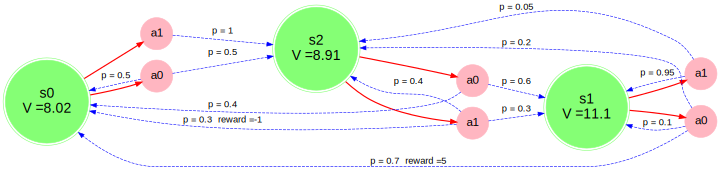

In [24]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [25]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 8.032) < 0.01
assert abs(state_values['s1'] - 11.169) < 0.01
assert abs(state_values['s2'] - 8.921) < 0.01

Final state values: {'s0': 8.023123818663871, 's1': 11.163174814980803, 's2': 8.915559364985523}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [26]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    # <YOUR CODE HERE>
    a_list = []
    v_list = []
    for a in mdp.get_possible_actions(state):
        a_list.append(a)
        v_list.append(get_action_value(mdp, state_values, state, a, gamma))
    index = np.argmax(v_list)
    return a_list[index]

In [27]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a0'

7.622407432642227
8.02400342848697
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885


7.622407432642227
8.02400342848697
7.622407432642227
8.02400342848697
11.164054424803906
9.945714638232934
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
8.916438974808628
8.08990200247885


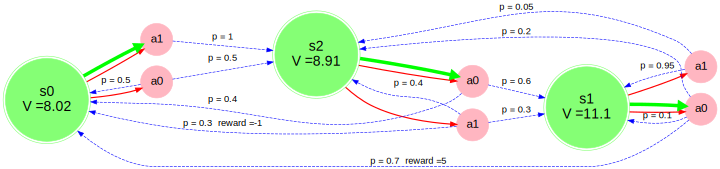

In [28]:
if has_graphviz:
    try:
        display(plot_graph_optimal_strategy_and_state_values(mdp, state_values))
    except ImportError:
        raise ImportError("Run the cell that starts with \"%%writefile mdp_get_action_value.py\"")

In [29]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.85 < np.mean(rewards) < 1.0)

7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.91643897

8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164

8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
11.164054424803906
9.945714638232934
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.0899

8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.

11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
11.164

11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.16405

9.945714638232934
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
7.622407432642227
8.02400342848697
8.916438974808628
8.08990200247885
11.164054424803906
9.945714638232934
7.622407432642227
8.02400

### Frozen lake

In [35]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [36]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        # <YOUR CODE HERE >
        new_state_values =  {s: get_new_state_value(mdp, state_values, s, gamma) for s in state_values.keys()}

        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [37]:
state_values = value_iteration(mdp)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
iter    0   |   diff: 1.00000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.9
1.0
0.0
iter    1   |   diff: 0.90000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.81
0.0
0.0
0.9
0.0
0.0
0.0
0.81
0.9
0.0
0.81
0.9
1.0
0.81
iter    2   |   diff: 0.81000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    3   |   diff: 0.72900   |   V(start): 0.00

In [38]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
down

SFFF
*HFH
FFFH
HFFG

0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
down

SFFF
FHFH
*FFH
HFFG

0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
right

SFFF
FHFH
F*FH
HFFG

0.6561000000000001
0.81
0.81
0.0
down

SFFF
FHFH
FFFH
H*FG

0.0
0.81
0.9
0.7290000000000001
right

SFFF
FHFH
FFFH
HF*G

0.81
0.9
1.0
0.81
right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
iter    0   |   diff: 1.00000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.9
1.0
0.0


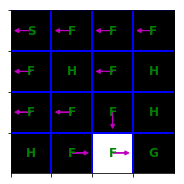

after iteration 1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.9
1.0
0.0
iter    0   |   diff: 0.90000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.81
0.0
0.0
0.9
0.0
0.0
0.0
0.81
0.9
0.0
0.81
0.9
1.0
0.81


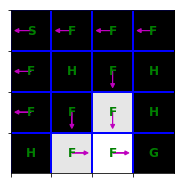

after iteration 2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.81
0.0
0.0
0.9
0.0
0.0
0.0
0.81
0.9
0.0
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.81000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81


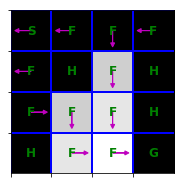

after iteration 3
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.72900   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.6561000000000001
0.0
0.0
0.7290000000000001
0.0
0.6561000000000001
0.6561000000000001
0.0
0.0
0.0
0.0
0.6561000000000001
0.0
0.0
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.0
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81


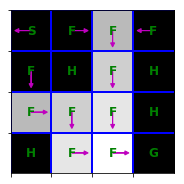

after iteration 4
0.0
0.0
0.0
0.0
0.0
0.0
0.6561000000000001
0.0
0.0
0.7290000000000001
0.0
0.6561000000000001
0.6561000000000001
0.0
0.0
0.0
0.0
0.6561000000000001
0.0
0.0
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.0
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.65610   |   V(start): 0.000 
0.0
0.5904900000000002
0.5904900000000002
0.0
0.0
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.0
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81


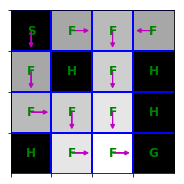

after iteration 5
0.0
0.5904900000000002
0.5904900000000002
0.0
0.0
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.0
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.59049   |   V(start): 0.590 
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.65

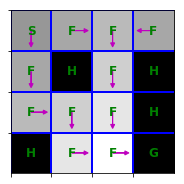

after iteration 6
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.00000   |   V(start): 0.590 
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.656

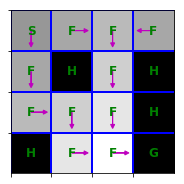

after iteration 7
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.00000   |   V(start): 0.590 
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.656

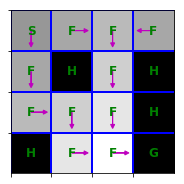

after iteration 8
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.00000   |   V(start): 0.590 
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.656

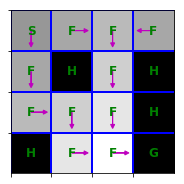

after iteration 9
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    0   |   diff: 0.00000   |   V(start): 0.590 
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5314410000000002
0.0
0.6561000000000001
0.5904900000000002
0.5904900000000002
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.6561000000000001
0.0
0.5904900000000002
0.5904900000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.0
0.81
0.0
0.6561000000000001
0.656

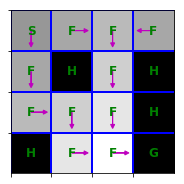

In [40]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
0.17858575307689448
0.18365563149921774
0.1981684335616138
0.17943944731585895
0.1808518808383202
0.20608047123182893
0.22234453053304482
0.20023934831224524
0.20299219638785357
0.23265650958286482
0.2493938602121421
0.22459789391663953
0.2278080301201617
0.26320597401522106
0.2796305131378171
0.25182518617611044
0.25621899039178686
0.3094394197274176
0.31337222528234676
0.28217342686289765
0.287159522081636
0.3479556234668964
0.3501900594269184
0.3153591444201669
0.32102931450672306
0.39118770221758725
0.3889979279563766
0.35215517800485857
0.3584501750270323
0.43410192748245174
0.3932106976185913
0.38876059453297834
0.18216594551015866
0.17276651928101178
0.20337356473110288
0.17999818659935574
0.18422070582900107
0.19150993908860311
0.22955578700659218
0.20092128163722212
0.20740143402928926
0.20783934739612847
0.25934276277310475
0.225554666736567
0.22265100685815614
0.02728695155877356
0.29368086707410623
0.25378766442781847
0.26866501782421737
0.331056913900833

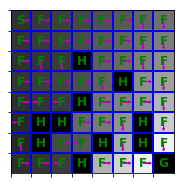

In [41]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [42]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
iter    0   |   diff: 1.00000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.0
0.0
0.9
0.0
0.0
0.9
1.0
0.0
iter    1   |   diff: 0.90000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.81
0.0
0.0
0.9
0.0
0.0
0.0
0.81
0.9
0.0
0.81
0.9
1.0
0.81
iter    2   |   diff: 0.81000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.0
0.0
0.0
0.7290000000000001
0.0
0.0
0.81
0.81
0.0
0.7290000000000001
0.9
0.0
0.7290000000000001
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
iter    3   |   diff: 0.72900   |   V(start): 0.00

0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.59049000000

0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.59049000000

0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0

0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.

0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000

0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.

0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6561000000000001
0.0
0.5314410000000002
0.6561000000000001
0.0
0.7290000000000001
0.5904900000000002
0.6561000000000001
0.81
0.81
0.0
0.0
0.81
0.9
0.7290000000000001
0.81
0.9
1.0
0.81
0.5314410000000002
0.5904900000000002
0.5904900000000002
0.5314410000000002
0.5904900000000002
0.6

In [43]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.05
0.9
0.05
iter    0   |   diff: 0.90000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.04050000000000001
0.7290000000000001
0.04050000000000001
0.0
0.0
0.04050000000000001
0.7290000000000001
0.04050000000000001
0.04050000000000001
0.7790000000000001
0.9405
0.05
iter    1   |   diff: 0.72900   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03280500000000001
0.5904900000000002
0.03280500000000001
0.0
0.0
0.0
0.0
0.0
0.03280500000000001
0.6232950000000002
0.6232950000000002
0.03280500000000001
0.042322500000000006
0.7618050000000001
0.042322500000000006
0.0
0.03280500000000001
0.6328125000000002
0.79461
0.042322500000000006
0.6656175000000002
0.8446100000000001
0.9

0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0

0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.0

0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523


0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933

0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0

0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534


0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.6982959203451701
0.8296779101616557
0.07440940000895127
0.5790120144812692
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8

0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.4438591132674443
0.4901794134837635
0.4516996401701141
0.44159559719017083
0.4968747807268181
0.5501582499269857
0.05124695330720523
0.42180111264933207
0.5501582499269857
0.06384931492999404
0.6486436218595306
0.509477142349607
0.5644959183764477
0.7702303175839933
0.7111338669022622
0.06652445807406457
0.07375513221367487
0.7478735010610819
0.8687726801344295
0.6680541618873719
0.7852090064460534
0.8841123178935285
0.9815031469361246
0.7611338669022623


In [44]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.125
0.75
0.125
iter    0   |   diff: 0.75000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.084375
0.5062500000000001
0.084375
0.0
0.0
0.084375
0.5062500000000001
0.084375
0.084375
0.6312500000000001
0.834375
0.125
iter    1   |   diff: 0.50625   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.056953125000000014
0.34171875000000007
0.056953125000000014
0.0
0.0
0.0
0.0
0.0
0.056953125000000014
0.39867187500000006
0.39867187500000006
0.056953125000000014
0.0938671875
0.563203125
0.0938671875
0.0
0.056953125000000014
0.4355859375000001
0.6201562500000001
0.0938671875
0.49253906250000007
0.7451562500000001
0.9008203125
0.5236718750000001
iter    2   |   diff: 0.39867  

0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.252396473166078
0.08022116121146994
0.29539349319963804
0.2796101585021589
0.2967370874449165
0.3883895463710716
0.2967370874449165
0.3286249927480862
0.252396473166078
0.08022116121146994
0.29539349319963804
0.2796101585021589
0.2967370874449165
0.3883895463710716
0.2967370874449165
0.3286249927480862
0.29539349319963804
0.07692516515697981
0.23262049683913716
0.2763141624476688
0.2967370874449165
0.3883895463710716
0.296737087444916

0.6128984641679531
0.7065611578716045
0.15880079333447789
0.3976094924130878
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392

0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.6128984641679531
0.7065611578716045
0.15880079333447789
0.3976094924130878
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.559244

0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484

0.2796101585021589
0.2967370874449165
0.3883895463710716
0.2967370874449165
0.3286249927480862
0.12318176464887193
0.4769285942420417
0.12318176464887193
0.26216199365118986
0.6128984641679531
0.7065611578716045
0.15880079333447789
0.3976094924130878
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.252396473166078
0.08022116121146994
0.29539349319963804
0.2796101585021589
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.56649263

0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.8454422580

0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.252396473166078
0.08022116121146994
0.29539349319963804
0.2796101585021589
0.2967370874449165
0.3883895463710716
0.2967370874449165
0.3286249927480862
0.12318176464887193
0.4769285942420417
0.12318176464887193
0.26216199365118986
0.6128984641679531
0.7065611578716045
0.15880079333447789
0.3976094924130878
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.6128984641679531
0.7065611578716045
0.15880079333447789
0.3976094924130878
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.092393325154848

0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254194
0.13154877469082307
0.4965868164245539
0.3864836482372953
0.42475902260537424
0.6727382003557169
0.5664926395359527
0.13535392859225082
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.16524699043282354
0.6425306405522481
0.7961252031655155
0.5592440396222572
0.7220187395925883
0.845442258026603
0.9346344678291223
0.6914926395359527
0.2981816148116468
0.32469386869785866
0.278405638484706
0.28892396876901627
0.34732819870132103
0.37768412290254194
0.09239332515484885
0.2616541192087085
0.37768412290254

In [45]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.8
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.8
0.1
iter    0   |   diff: 0.80000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.8003676837105377
0.8791208791208791
0.1674006507435048
iter   15   |   diff: 0.02910   |   V(start): 0.087 
0.07912564459097339
0.08563940754695576
0.10597029748479345
0.08203005743923591
0.08579348330812317
0.11553580051225136
0.13982482517728181
0.1122730464549733
0.11904387398945945
0.14608482203755035
0.17130437567504167
0.14594954363081983
0.15276884322480253
0.17988895111654601
0.20322956463333314
0.17759505605026668
0.18621021195886983
0.22758178173922577
0.23563763698993428
0.20912125587893127
0.2182863757766417
0.2634263836746932
0.2679086019100563
0.2395328495240743
0.24963125199209774
0.3024100144565419
0.30021613762841987
0.2712450208457692
0.28223553263643614
0.33678511909554765
0.3072387084721213
0.29944591040653395
0.08228954549174984
0.0829348269120333
0.10878760233512813
0.08288907045986064
0.08705286791320271
0.09720415505543523
0.13761013808137204
0.1127411250192796
0.1184534218271498
0.1159537534212933
0.1697450645217333
0.1466441247712645
0.134861792843072
0.0378

0.06421879500314454
0.010672040830303249
0.10316288811425067
0.15296453260490067
0.01778656147182468
0.13311716214601446
0.013766806822676067
0.02298270756460592
0.1976284673395234
0.10501389304409503
0.539205233952039
0.10501389304409503
0.3009059104007212
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.07103732855254098
0.07370530118550876
0.0805775761846591
0.06190176775388466
0.06645402416235936
0.08547378167076597
0.09382013461959016
0.01792331785345265
0.09198931147029264
0.09382013461959016
0.024438847652979316
0.1185782625585727
0.053327990171080634
0.49402457561264995
0.5925332241231196
0.06740065424400488
0.5425530466683334
0.6716541032439987
0.7488961582667213
0.5206766377374271
0.6183261130729181
0.8003676872110378
0.8791208791208791
0.16740065424400488
iter   30   |   diff: 0.00004   |   V(start): 0.141 
0.1262229081884091
0.12477118273937293
0.14077135651318975
0.12850864729895434
0.12984617579241392
0.14128142145056696
0.16097499374868404
0

0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.12431585378724817
0.12596638979465968
0.15563309560371638
0.14422339759755767
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940

0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.07778058189699655
0.3850564131461318
0.4498157636632589
0.3301970374714061
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.31132240162899694
0.08757083711403177
0.4702111326530314
0.41143818659312864
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332

0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.3172270

0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.63364592

0.19108866865430282
0.19566761804440008
0.24009278535156625
0.26273170243089555
0.21836897503643338
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.210174218

0.2732766388758004
0.2839397592277309
0.3374123981648326
0.30826895298348017
0.3006300045638942
0.3196219390162854
0.3884990526678788
0.35038830948338484
0.30902095587521006
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.12431585378724817
0.12596638979465968
0.15563309560371638
0.14422339759755767
0.14131886916524006
0.1343586795647115
0.17908266514725205
0.16521648755397714
0.14785509595497243
0.039763279130146614
0.208082

0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.19566761804440008
0.24009278535156625
0.26273170243089555
0.21836897503643338
0.046020321212645265
0.20696803491079094
0.2697985291034361
0.2171390867630689
0.19566761804440008
0.24009278535156625
0.26273170243089555
0.21836897503643338
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.

0.35038830948338484
0.30902095587521006
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.34576798

0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.07778058189699655
0.3850564131461318
0.4498157636632589
0.3301970374714061
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.31132240162899694
0.08757083711403177
0.4702111326530314
0.41143818659312864
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.44765754

0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.12431585378724817
0.12596638979465968
0.15563309560371638
0.14422339759755767
0.14131886916524006
0.1343586795647115
0.17908266514725205
0.16521648755397714
0.14785509595497243
0.039763279130146614
0.20808248446723956
0.19108866865430282
0.19566761804440008
0.24009278535156625
0.26273170243089555
0.21836897503643338
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31

0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.28068307

0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.243306710

0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12115388229951343
0.11310529753838539
0.13558726654469339
0.12756775355913186
0.12431585378724817
0.12596638979465968
0.15563309560371638
0.14422339759755767
0.14131886916524006
0.1343586795647115
0.17908266514725205
0.16521648755397714
0.14785509595497243
0.039763279130146614
0.20

0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.12431585378724817
0.12596638979465968
0.15563309560371638
0.14422339759755767
0.11280977214872334
0.11882296

0.3013820074556241
0.2732766388758004
0.2839397592277309
0.3374123981648326
0.30826895298348017
0.3006300045638942
0.3196219390162854
0.3884990526678788
0.35038830948338484
0.30902095587521006
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017

0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.241440880989592
0.278543177507947
0.30122701637340116
0.2491793234293409
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.07778058189699655
0.3850564131461318
0.4498157636632589
0.3301970374714061
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.57992996014

0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.3196219390162854
0.3884990526678788
0.35038830948338484
0.30902095587521006
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902

0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.3196219390162854
0.3884990526678788
0.35038830948338484
0.30902095587521006
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.07778058189699655
0.3850564131461318
0.4498157636632589
0.3301970374714061
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.31132240162899694
0.08757083711403177
0.4702111326530314
0.41143818659

0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.1485808902769264
0.1623429956122853
0.1840030825425796
0.16588569523076685
0.17012521565785105
0.18794601645045936
0.2101742180942439
0.1894520452994389
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.1965376314111621
0.23238427869376266
0.23962659569919062
0.21574859223636988
0.22394334917855938
0.2657758017604557
0.2700199541301731
0.24330671051096825
0.2528594382411185
0.30362185576538864
0.3013820074556241
0.2732766388758004
0.27967099118936767
0.3457679849617859
0.3425068627553242
0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.40940

0.2806830744821036
0.29538074484574406
0.39214150294286554
0.3940175567743123
0.31722709962429796
0.3651619520498597
0.4477986392125102
0.4038843321185955
0.35548277407387646
0.41788519120253476
0.5167155303738142
0.4660530234897003
0.409402836225029
0.44765754827473947
0.5968440472030478
0.5388332468175348
0.46807014794044904
0.13283684336689716
0.6955681680956406
0.6336459243957583
0.49232884909675195
0.16260113512860766
0.8791208791208791
0.7955681680956406
0.5799299601497403
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.1609769671268929
0.1451332169209308
0.12431585378724817
0.12596638979465968
0.15563309560371638
0.14422339759755767
0.14131886916524006
0.1343586795647115
0.17908266514725205
0.16521648755397714
0.14785509595497243
0.039763279130146614
0.20808248446723956
0.19108866865430282
0.1262305623995473
0.12477983453235858
0.1407757242415621
0.1285156895008621
0.12985288066044665
0.14128558435559246
0.16

## Bonus area

### Bonus 1 - find an MDP for which value iteration takes long to converge  (2+ pts)

When we ran value iteration on the small frozen lake problem, the last iteration where an action changed was iteration 6--i.e., value iteration computed the optimal policy at iteration 6. Are there any guarantees regarding how many iterations it'll take value iteration to compute the optimal policy? There are no such guarantees without additional assumptions--we can construct the MDP in such a way that the greedy policy will change after arbitrarily many iterations.

Your task: define an MDP with at most 3 states and 2 actions, such that when you run value iteration, the optimal action changes at iteration >= 50. Use discount=0.95. (However, note that the discount doesn't matter here--you can construct an appropriate MDP with any discount.)

Note: value function must change at least once after iteration >=50, not necessarily change on every iteration till >=50.

In [ ]:
transition_probs = {
    < YOUR CODE >
}
rewards = {
    < YOUR CODE >
}

from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))
# Feel free to change the initial_state

In [ ]:
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    print("N actions changed = %i \n" % n_changes)
    policy = new_policy

# please ignore iter 0 at each step

### Bonus 2 - Policy Iteration (3+ points)

Let's implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$   `// random or fixed action`

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

Unlike VI, policy iteration has to maintain a policy - chosen actions from all states - and estimate $V^{\pi_{n}}$ based on this policy. It only changes policy once values converged.


Below are a few helpers that you may or may not use in your implementation.

In [49]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Let's write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.

Unlike VI, this time you must find the exact solution, not just a single iteration.

Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

You'll have to solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve`.)

In [59]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    # YOUR CODE HERE
    
    V_PI = {s:get_action_value(mdp, state_values, s, policy[s], gamma) for s in state_values.keys()}
    return V_PI

In [61]:
state_values = {s: 0 for s in mdp.get_all_states()}
test_policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

0.0
3.5
0.0
{'s0': 0.0, 's1': 3.5, 's2': 0.0}


Once we've got new state values, it's time to update our policy.

In [64]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    #<YOUR CODE >
    new_policy = {s : get_optimal_action(mdp = mdp, state_values = state_values, state = s, gamma=gamma) for s in vpi.keys()}
    return new_policy

In [65]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

0.0
0.0
3.5
0.0
0.0
-0.3
{'s0': 'a0', 's1': 'a0', 's2': 'a0'}


__Main loop__

In [66]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ 
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.
    """
    #< A WHOLE LOT OF YOUR CODE >
    for n in range(num_iter):
        V_PI = compute_vpi(mdp, policy, gamma)
        policy = compute_new_policy(mdp, V_PI, gamma)
        
        # Compute difference
        diff = max(abs(V_PI[s] - state_values[s]) for s in mdp.get_all_states())
        print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
        print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()), end='\n\n')
        state_values = V_PI

        if diff < min_difference:
            print("Terminated")
            break

    return state_values, policy

__Your PI Results__

In [68]:
#< Compare PI and VI on the MDP from bonus 1, then on small & large FrozenLake >
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    print("after iteration %i" % i)
    state_values,  new_policy =  policy_iteration(mdp, policy=policy, gamma=0.9, num_iter=1000, min_difference=1e-5)

    n_changes = (policy != new_policy).sum()
    print("N actions changed = %i \n" % n_changes)
    policy = new_policy

0.0
0.0
3.5
0.0
0.0
-0.3
after iteration 0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices